In [6]:
import  lib_Experimentum    as      Exp
from    Alessandria         import  *
from    Models              import  S_2_Generate, S_Dynamical_Form_Factor_2, S_Dynamical_Form_Factor_0, S_0_Generate

import pandas as pd
import  numpy               as      np
from    scipy.io            import  loadmat

from    matplotlib.pyplot   import  plot
import  matplotlib.pyplot   as      plt
from    os.path             import join

import  time
import configparser


save_path = join('..', 'Scrittek', 'figures')
#
#I/O 
spectra_filename    =   'ARS_10_02'
now_path            =   join('..', 'BRILLOUIN', 'TDP43', spectra_filename)


inputs = configparser.ConfigParser()

with open(join(now_path,'config.ini'), 'r') as f:
    inputs.read_file(f)


############
#I/O 

VIPA_filename       =   inputs['I/O']['VIPA_filename']
log_file            =   'log_'+spectra_filename
transpose           =   inputs.getboolean('I/O', 'transpose')

#operatives
to_add              =   eval(inputs['Operatives']['to_add'])
exclude_delta       =   inputs.getboolean('Operatives', 'exclude_delta')

syg_kwargs          =  {item[0] : float(item[1]) for item in inputs.items('syg_kwargs')}
syg_kwargs_VIPA     =  {item[0] : float(item[1]) for item in inputs.items('syg_kwargs_VIPA')}
syg_kwargs_brill    =  {item[0] : float(item[1]) for item in inputs.items('syg_kwargs_brill')}
pre_cut             =  inputs.getboolean('Operatives','pre_cut')
pre_cut_range       =  None#eval(inputs['Operatives']['pre_cut_range'])
VIPA_treshold       =  inputs.getfloat('Operatives','VIPA_treshold')
sat_height          =  inputs.getfloat('Operatives','sat_height')
sat_width           =  inputs.getfloat('Operatives','sat_width')
almost_treshold     =  inputs.getfloat('Operatives','almost_treshold')
cut                 =  inputs.getboolean('Operatives','cut')
mean_dist_01        =  inputs.getfloat('Operatives','mean_dist_01')
mean_dist_23        =  inputs.getfloat('Operatives','mean_dist_23')
#markov_fit

recover_markov      = inputs.getboolean('Markov', 'recover_markov')
p0_normal           = np.array(eval(inputs['Markov']['p0_normal']))
p0_almost           = np.array(eval(inputs['Markov']['p0_almost']))

rules_markov_bounds =   eval(inputs['Markov']['rules_markov_bounds'])
#tot fit
skip_tot            =  inputs.getboolean('Tot', 'skip_tot')
rules_tot_bounds    =   eval(inputs['Tot']['rules_tot_bounds'])


############


cols_basic  = ('Co', 'Omega', 'Gamma', 'delta_position', 'delta_width',  'delta_amplitude')
cols        = ('Co', 'Omega', 'Gamma', 'Delta', 'tau', 'delta_position',  'delta_width', 'delta_amplitude', 'A', 'mu', 'sigma', 'shift', 'offset')
cols_mark   = ('Co', 'Omega', 'Gamma', 'delta_position', 'delta_width',  'delta_amplitude', 'A', 'mu', 'sigma', 'shift', 'offset')
cols_mark_nodelta  = ('Co', 'Omega', 'Gamma', 'A', 'mu', 'sigma', 'shift', 'offset')
cols_real   = ('Co', 'Omega', 'Gamma', 'Delta', 'tau', 'delta_position', 'delta_width', 'delta_amplitude','shift', 'offset')
cols_real_nodelta =  ('Co', 'Omega', 'Gamma', 'Delta', 'tau', 'shift', 'offset')

cols_gauss  = ( 'A', 'mu', 'sigma')
print('Acquisito file config.ini da {}\nOK, variabili operative:\npre_cut = {}\ntranspose = {}\nexculde delta = {}\nbounds markov = {}'.format(now_path, pre_cut, transpose, exclude_delta, str(rules_markov_bounds)))

Acquisito file config.ini da ../BRILLOUIN/TDP43/ARS_10_02
OK, variabili operative:
pre_cut = True
transpose = False
exculde delta = True
bounds markov = ('positive', 0.2, 'positive', [-2, 2], 'positive', 'positive', 'positive', 0.01, 0.001, 'inf', 'inf')


In [7]:
VIPA_filename       =   'ARS_10_02_VIPA2'


In [8]:
#0) importo dati e inizializzo oggetti
i   =  0
j   =  76
y    =   Import_from_Matlab(spectra_filename, now_path, transpose = transpose)[i][j]
Data    =   Exp.Spectrum(name = str((i,j)))
Data.Get_Spectrum(y = np.resize(y, np.max(y.shape)), offset = 183., cut = pre_cut, cut_range = pre_cut_range)
Data.Get_Spectrum_Peaks(**syg_kwargs)
Data.Get_VIPA_tif(VIPA_filename, now_path, fig = VIPA_filename, save_path = now_path)

plt.figure()
plt.plot(Data.x, Data.y)
plt.title(str((i,j)))

Took data from matlab cell datatype. Variable name is y


TypeError: 'NoneType' object is not subscriptable

Lo spettro è normal
Lo spettro ha 4 picchi


Text(0.5, 1.0, '(0, 0)')

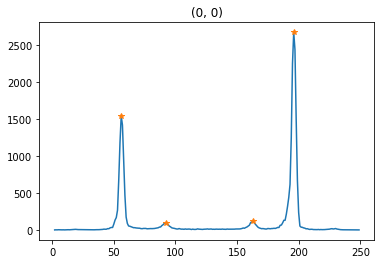

In [53]:
#1) Classificazione e visualizzazione spettro
check = Data.Check_Spectrum_Saturation(saturation_height = sat_height, saturation_width = sat_width)

if      check == 1  : nature    = 'saturo'
elif    (Data.n_peaks == 2) :

    Data.Get_Spectrum_Peaks(**syg_kwargs_brill)
    nature = 'brillouin_higher'

elif Data.y.max() > almost_treshold:
    nature = 'almost_height'
else:                 nature    = 'normal'

print('Lo spettro è '+nature)
print('Lo spettro ha {} picchi'.format(Data.n_peaks))
plt.figure()
plt.plot(Data.x, Data.y)
plt.plot(Data.x[Data.peaks['idx']], Data.y[Data.peaks['idx']], '*')
plt.title(str((i,j)))



 Ho trovato 4 picchi nel tuo spettro sperimentale con le caratteristiche richieste
 Altezza > 49.26 
 Spessore > 2.72 



 Il picco 1 ha: 	 indice = 54 	 x_value (pix) = 56.00 	 ampiezza(pix) = 4.17 	 altezza = 1543.24 


 Il picco 2 ha: 	 indice = 90 	 x_value (pix) = 92.00 	 ampiezza(pix) = 6.39 	 altezza = 89.12 


 Il picco 3 ha: 	 indice = 161 	 x_value (pix) = 163.00 	 ampiezza(pix) = 5.51 	 altezza = 116.24 


 Il picco 4 ha: 	 indice = 194 	 x_value (pix) = 196.00 	 ampiezza(pix) = 4.09 	 altezza = 2677.06 



{'n_peaks': 4,
 'idx': array([ 54,  90, 161, 194]),
 'peaks_width': array([4.16530942, 6.38745502, 5.51244388, 4.0945233 ]),
 'peak_heights': array([1543.23529412,   89.11764706,  116.23529412, 2677.05882353])}

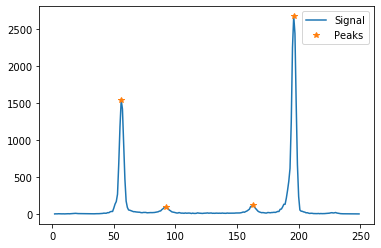

In [54]:
Analyze_Peaks(Data.x, Data.y, 'pix', height = 49.26, width = 2.723, distance = 31.6, fig = True, verbose = True)

In [55]:
Data.How_Many_Peaks_To(fig = True, verbose = True, width = 1.85, distance = 31.6)

Ho trovato valore dell'altezza per avere 4 picchi: 88.529412
 (array([ 54,  90, 161, 194]), {'peak_heights': array([1543.23529412,   89.11764706,  116.23529412, 2677.05882353]), 'prominences': array([1537.41176471,   73.82352941,  103.88235294, 2676.88235294]), 'left_bases': array([  0,  75, 111,   0]), 'right_bases': array([111, 111, 172, 243]), 'widths': array([4.16530942, 6.38745502, 5.51244388, 4.0945233 ]), 'width_heights': array([ 774.52941176,   52.20588235,   64.29411765, 1338.61764706]), 'left_ips': array([ 52.19472024,  86.63301282, 158.0201005 , 192.09240625]), 'right_ips': array([ 56.36002966,  93.02046784, 163.53254438, 196.18692955])})


AttributeError: 'Spectrum' object has no attribute 'x_freq'

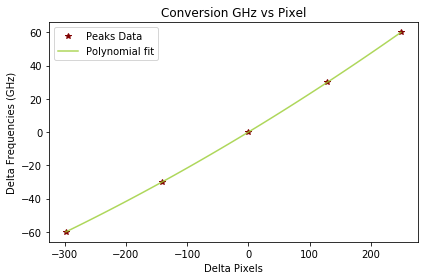

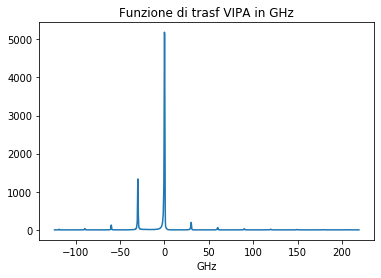

In [61]:
#2) Operazioni di conversione in GHz

Data.How_Many_Peaks_To_VIPA(treshold = VIPA_treshold, **syg_kwargs_VIPA)
Data.Fit_Pixel2GHz(fig = True, data_color = 'maroon', fit_color = 'yellowgreen', savepath = save_path)
Data.VIPA_Pix2GHz(fig = True)

In [62]:
"""
# PLOT del FIT gaussiano
f1, ax1 = plt.subplots()
ax1.plot(Data.x_VIPA, Data.y_VIPA, c = 'yellowgreen', alpha = 0.99, label = 'VIPA response function')
pk = find_peaks(Data.y_VIPA, height = 100., width = 1., distance = 100)
ax1.plot(Data.x_VIPA[pk[0]], Data.y_VIPA[pk[0]], '*', c = 'maroon', label = 'peaks')
ax1.xaxis.set_label_text('Delta Pixels')
ax1.yaxis.set_label_text('Intensity (a.u.)')
ax1.legend()
ax1.set_xlim(-400, 400)
plt.tight_layout()
f1.savefig(save_path+'VIPA_peaks.pdf', format = 'pdf')
"""

"\n# PLOT del FIT gaussiano\nf1, ax1 = plt.subplots()\nax1.plot(Data.x_VIPA, Data.y_VIPA, c = 'yellowgreen', alpha = 0.99, label = 'VIPA response function')\npk = find_peaks(Data.y_VIPA, height = 100., width = 1., distance = 100)\nax1.plot(Data.x_VIPA[pk[0]], Data.y_VIPA[pk[0]], '*', c = 'maroon', label = 'peaks')\nax1.xaxis.set_label_text('Delta Pixels')\nax1.yaxis.set_label_text('Intensity (a.u.)')\nax1.legend()\nax1.set_xlim(-400, 400)\nplt.tight_layout()\nf1.savefig(save_path+'VIPA_peaks.pdf', format = 'pdf')\n"

[594 735 864]
[-2.99772340e+01  1.20541367e-02  2.99611388e+01]


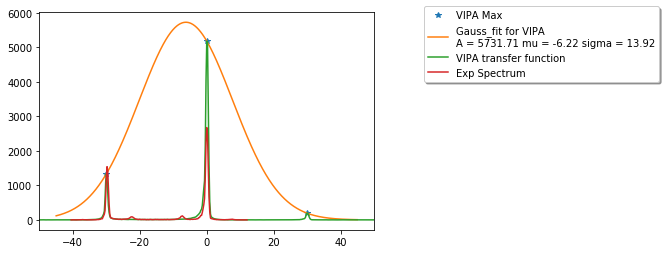

In [63]:
#3) Eseeguo taglio e stima parametri iniziali spettro, verifichepositive

Data.Align_Spectrum()
Data.Spectrum_Pix2GHz()#fig = True)
Data.Estimate_Spectrum_Parameters(verbose = True)
Data.Cut_Spectrum(mean_dist01 = mean_dist_01, mean_dist23 = mean_dist_23)
Data.Fit_VIPA_Gaussian(fig = True)


In [64]:
"""
STAMPA PER TESI
from Alessandria import gaussian
f, ax = plt.subplots()
ax.plot(Data.x_freq, Data.y, ls = 'solid', label = 'Experimental spectrum \nI($\omega$)', c = 'maroon')
ax.plot(Data.x_VIPA_freq, Data.y_VIPA, ls = 'dashed' , label = 'enveloped VIPA \nresponse V($\omega$) * G($\omega$)', c = 'yellowgreen')
x = np.linspace(-30,30,1000)
ax.plot(x, gaussian(x, *Data.p0[list(cols_gauss)].values[0]), label = 'gaussian envelope G($\omega$)', c = 'orange', ls = 'dotted')
ax.set_xlim(-35, 35)
ax.legend(loc = 'upper right')
ax.set_xlabel('Frequency shift $\omega$ (GHz)')
ax.set_ylabel('Intensity (a.u.)')
f.savefig('../Scrittek/figures/gauss_envelop.pdf', format = 'pdf')
#_ = Data.Gauss_Convolve_Markovian_Response(Data.p0[list(cols_mark)].values[0], fig = True, compare = True)
"""

"\nSTAMPA PER TESI\nfrom Alessandria import gaussian\nf, ax = plt.subplots()\nax.plot(Data.x_freq, Data.y, ls = 'solid', label = 'Experimental spectrum \nI($\\omega$)', c = 'maroon')\nax.plot(Data.x_VIPA_freq, Data.y_VIPA, ls = 'dashed' , label = 'enveloped VIPA \nresponse V($\\omega$) * G($\\omega$)', c = 'yellowgreen')\nx = np.linspace(-30,30,1000)\nax.plot(x, gaussian(x, *Data.p0[list(cols_gauss)].values[0]), label = 'gaussian envelope G($\\omega$)', c = 'orange', ls = 'dotted')\nax.set_xlim(-35, 35)\nax.legend(loc = 'upper right')\nax.set_xlabel('Frequency shift $\\omega$ (GHz)')\nax.set_ylabel('Intensity (a.u.)')\nf.savefig('../Scrittek/figures/gauss_envelop.pdf', format = 'pdf')\n#_ = Data.Gauss_Convolve_Markovian_Response(Data.p0[list(cols_mark)].values[0], fig = True, compare = True)\n"

Cost before fitting = 1625775.1424273967
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.6258e+06                                    3.48e+06    
       1              2         3.7894e+05      1.25e+06       5.73e+03       8.69e+05    
       2              3         8.3802e+04      2.95e+05       1.15e+04       2.17e+05    
       3              4         1.7363e+04      6.64e+04       1.02e+04       5.32e+04    
       4              5         4.6752e+03      1.27e+04       5.81e-02       3.51e+04    
       5              6         2.9767e+03      1.70e+03       2.27e+03       1.61e+04    
       6              7         2.3873e+03      5.89e+02       6.68e+03       3.87e+03    
       7              8         2.3111e+03      7.62e+01       2.13e+04       8.46e+02    
       8              9         2.3092e+03      1.92e+00       2.26e+04       6.79e+02    
       9             10         2.3090e+03      2

,Co,Omega,Gamma,delta_position,delta_width,delta_amplitude,A,mu,sigma,shift,offset
Values,0.004479,7.446022,0.119373,-0.005411,0.056867,0.071346,7.168680e+03,-6.283675,13.904836,-0.023436,-0.655254
StdErrs,0.000208,0.029678,0.017494,0.001361,0.001409,0.000574,3.809833e+09,0.990542,0.665717,0.029665,0.149687
Initials,0.010000,7.561185,0.100000,0.000000,0.100000,1.000000,5.731713e+03,-6.221460,13.918754,0.000000,0.000000


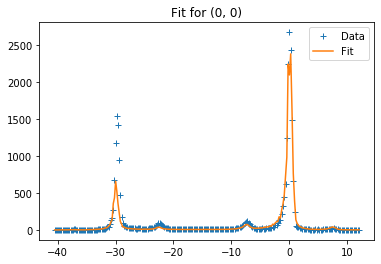

In [65]:
#3) fit markoviano
exclude_delta = False
if (exclude_delta) & (nature != 'almost_height'):
    print('porcodio')
    columns = cols_mark_nodelta
    rules_bounds = {key : rules_markov_bounds[key] for key in columns}
    Data.Get_Fit_Bounds(rules_vounds, columns)
else:
    columns = cols_mark
    Data.Get_Fit_Bounds(rules_markov_bounds, columns)

Data.Get_VIPA_for_fit(mode = 'interpolate', interpolation_density = 500)

p0s = [Data.p0[list(columns)].values[0]]#, p0_almost, p0_brillouin, p0_normal]
Data.Get_Best_p0(p0s, columns)
Data.Get_cost_markov(Data.p0[list(columns)].values[0], columns = columns)
print('Cost before fitting = {}'.format(Data.cost_markov))


_= Data.Non_Linear_Least_Squares_Markov(columns, fig = True, zoom = False,  bounds = (Data.bounds['down'].values, Data.bounds['up'].values), verbose = 2, max_nfev = 200, method = 'trf',)
#_= Data.Non_Linear_Least_Squares_Markov(columns, verbose = 2, max_nfev = 200, fig = True, zoom = False, method = 'lm')
Data.Get_cost_markov(Data.Markov_Fit_Params.values[0], columns = columns)
print('Cost after fitting = {}\n'.format(Data.cost_markov))
Data.Markov_Fit_Params

In [66]:
Data.Markov_Fit_Params[list(columns)].values[0]

array([ 4.47878847e-03,  7.44602179e+00,  1.19372730e-01, -5.41093640e-03,
        5.68669007e-02,  7.13459150e-02,  7.16867979e+03, -6.28367498e+00,
        1.39048357e+01, -2.34364951e-02, -6.55254330e-01])

The maximum number of function evaluations is exceeded.
Function evaluations 50, initial cost 2.3106e+03, final cost 2.2818e+03, first-order optimality 2.59e+02.
s impiegati a fare il fit totale  16.513930989000016 



,Co,Omega,Gamma,Delta,tau,delta_position,delta_width,delta_amplitude,shift,offset
Values,0.004340,7.900854,0.158448,-1.406783,0.709812,-0.005418,0.057101,0.071679,-0.022056,-0.675674
StdErrs,0.000502,0.676282,0.052495,3.928004,1.216490,0.001362,0.001608,0.000750,0.028218,0.151164
Initials,0.004479,7.446022,0.119373,0.119373,1.000000,-0.005411,0.056867,0.071346,-0.023436,-0.655254


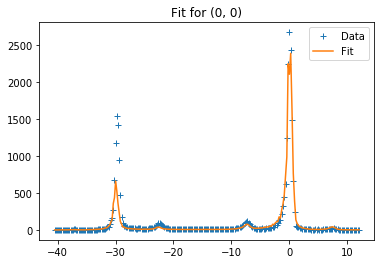

In [67]:
#4) fit totale
p_gauss = Data.Markov_Fit_Params[list(cols_gauss)].values[0]


columns = cols_real


Data.Initials_Parameters_from_Markov()
Data.Get_Fit_Bounds(rules_tot_bounds, columns)

#_ = Data.Non_Linear_Least_Squares(p_gauss, columns, bounds = (Data.bounds['down'].values, Data.bounds['up'].values), verbose = 2, fig = True, max_nfev = 50, method = 'trf')
_ = Data.Non_Linear_Least_Squares(p_gauss, columns, verbose = 2, fig = True, max_nfev = 50, method = 'lm')
Data.Tot_Fit_Params

In [12]:
Data.Markov_Fit_Params

,Co,Omega,Gamma,delta_position,delta_width,delta_amplitude,A,mu,sigma,shift,offset
Values,0.004521,7.380684,0.159536,-0.108479,0.057510,0.021759,7.267750e+02,-6.283675,13.904836,-0.152516,-0.316853
StdErrs,0.000195,0.031520,0.017364,0.002655,0.002641,0.000308,8.543017e+08,0.973789,0.653424,0.031479,0.133410
Initials,0.010000,7.556025,0.100000,0.000000,0.100000,1.000000,5.731713e+03,-6.221460,13.918754,0.000000,0.000000
